In [1]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 4.7 MB/s eta 0:00:00


In [2]:
import sqlite3
import numpy as np
import pandas as pd
from catboost import CatBoostClassifier, Pool, cv
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from tqdm import tqdm

# Загрузка данных из SQLite
con = sqlite3.connect("/content/drive/MyDrive/Colab Notebooks/src/dataset.sqlite")
dataset = "dataset_2012-23"
df = pd.read_sql_query(f"SELECT * FROM \"{dataset}\"", con, index_col="index")
con.close()



In [3]:
# Создание новых признаков
# Эффективность атаки
df['EFF_FG'] = (df['FGM'] + 0.5 * df['FG3M']) / df['FGA']
df['EFF_FG.1'] = (df['FGM.1'] + 0.5 * df['FG3M.1']) / df['FGA.1']

# Разница в среднем количестве очков
df['AVG_PTS_DIFF'] = df['PTS'] - df['PTS.1']

# Отношение побед к проигрышам
df['W_L_RATIO'] = df['W'] / (df['L'] + 1)
df['W_L_RATIO.1'] = df['W.1'] / (df['L.1'] + 1)

# Показатели эффективности защиты
df['DEF_EFF'] = df['STL'] + df['BLK'] - df['BLKA']
df['DEF_EFF.1'] = df['STL.1'] + df['BLK.1'] - df['BLKA.1']

# Перевес в ребаундах
df['REB_DIFF'] = df['REB'] - df['REB.1']

# Перевес в ассистах
df['AST_DIFF'] = df['AST'] - df['AST.1']

# Перевес в потерях
df['TOV_DIFF'] = df['TOV'] - df['TOV.1']

# Скользящие средние
# Например, можно вычислить скользящие средние по очкам за последние 5 игр.
df['AVG_PTS_LAST_5'] = df['PTS'].rolling(window=5).mean()

# Взаимодействие признаков
# Пример: Взаимодействие процента побед и среднего количества очков
df['W_PCT_PTS'] = df['W_PCT'] * df['PTS']
df['W_PCT_PTS.1'] = df['W_PCT.1'] * df['PTS.1']


In [ ]:
# Определение целевой переменной и удаление её из набора данных
target = df['Home-Team-Win']
features = df.drop(['Score', 'Home-Team-Win', 'TEAM_NAME', 'Date', 'TEAM_NAME.1', 'Date.1', 'OU-Cover', 'OU','STL','FT_PCT_RANK','FG3_PCT.1','REB','PFD.1','BLK.1','MIN','TOV.1','FG3A_RANK.1','FG3M_RANK.1','FTA_RANK.1','PTS_RANK.1','REB.1','FG3A_RANK','PF1','DREB','FG3_PCT','FG3M_RANK.1','PTS_RANK','STL.1','OREB','OREB_RANK','FGM.1'], axis=1)

# Конвертация данных в формат, подходящий для CatBoost
X = features.values.astype(float)
y = target.values.astype(float)

# Разделение данных на обучающий и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Параметры для Grid Search
param_grid = {
    #'depth': [2,4, 6, 8, 10],
    'depth': [2, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'iterations': [500, 1000],
    'l2_leaf_reg': [2,3,4, 5]
}

# Инициализация CatBoostClassifier
catboost_model = CatBoostClassifier(loss_function='Logloss', verbose=False)

# Настройка Grid Search
grid_search = GridSearchCV(estimator=catboost_model, param_grid=param_grid, cv=3, scoring='accuracy')

# Выполнение Grid Search
print("Starting Grid Search...")
grid_search.fit(X_train, y_train)

# Вывод лучших параметров
print('Best parameters found by grid search:', grid_search.best_params_)
print('Best accuracy by grid search:', grid_search.best_score_)

# Обучение модели с лучшими параметрами
best_model = CatBoostClassifier(**grid_search.best_params_)
best_model.fit(X_train, y_train)

# Оценка модели на тестовых данных
predictions = best_model.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy of the best model on test data: {accuracy}")


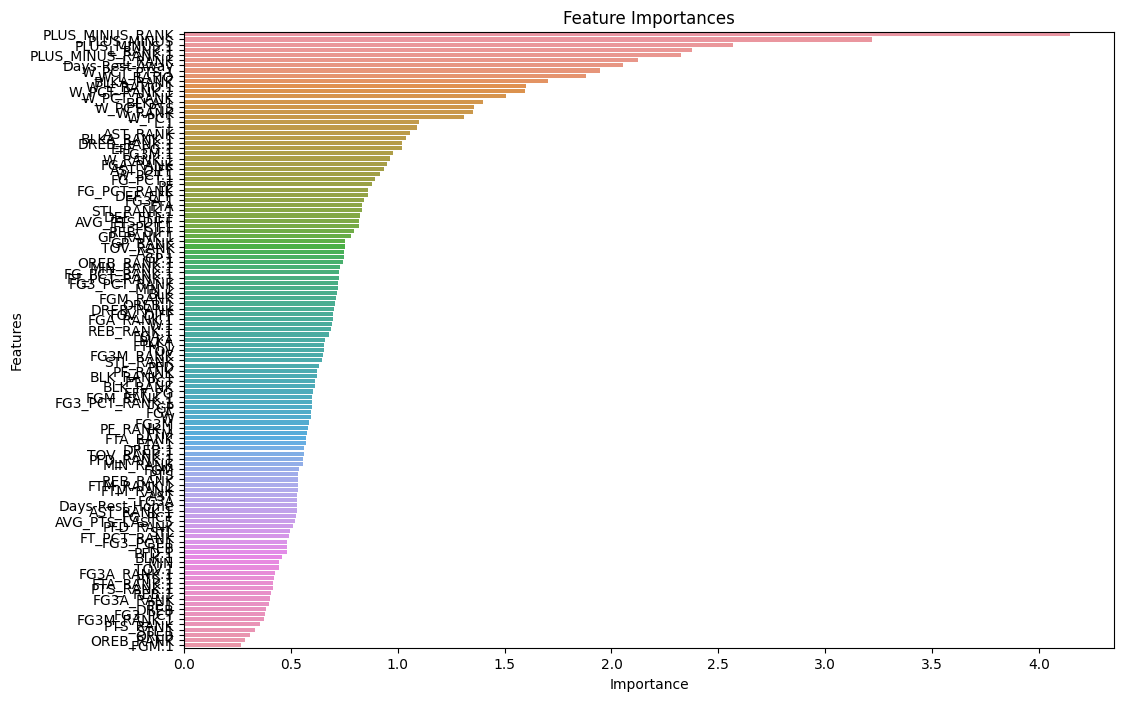

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Обучаем модель (предполагается, что best_model уже обучена)
# best_model.fit(X_train, y_train)

# Получаем важность функций
feature_importances = best_model.get_feature_importance()

# Создаем DataFrame, содержащий имена функций и их важности
features_df = pd.DataFrame({
    'Features': features.columns,
    'Importance': feature_importances
})

# Сортируем функции по важности
features_df = features_df.sort_values(by='Importance', ascending=False)

# Создаем график важности функций
plt.figure(figsize=(12, 8))
sns.barplot(x="Importance", y="Features", data=features_df)
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()


In [7]:
# Фильтруем DataFrame, чтобы оставить только значения с важностью < 0.5
low_importance_features = features_df[features_df['Importance'] < 0.5]

# Выводим список признаков с их важностями
print(low_importance_features)
# Выводим только значения важности признаков < 0.5
#print(low_importance_features['Importance'])


        Features  Importance
19           STL    0.494619
39   FT_PCT_RANK    0.491235
62     FG3_PCT.1    0.483071
16           REB    0.482168
75         PFD.1    0.481728
72         BLK.1    0.460633
4            MIN    0.446208
70         TOV.1    0.443353
87   FG3A_RANK.1    0.424977
76         PTS.1    0.419457
90    FTA_RANK.1    0.417086
102   PTS_RANK.1    0.416928
68         REB.1    0.407488
35     FG3A_RANK    0.401391
74          PF.1    0.396907
15          DREB    0.382858
10       FG3_PCT    0.379126
86   FG3M_RANK.1    0.373554
50      PTS_RANK    0.355424
71         STL.1    0.333214
14          OREB    0.308777
40     OREB_RANK    0.283724
57         FGM.1    0.265444
